In [1]:
import polars as pl
import plotly.express as px
import plotly.graph_objects as go
import re
import glob
import numpy as np

In [2]:
def load_gemm_data(path: str):
    files = glob.glob(path + "/*.jsonl")
    pattern = re.compile(r"M(\d+)_N(\d+)_K(\d+)")
    
    dfs = []
    for file in files:
        match = pattern.search(file)
        if match:
            M, N, K = match.groups()
            df = pl.read_ndjson(file).filter(pl.col("is_best") == "true")
            dfs.append(df)
    
    if dfs:
        combined_df = pl.concat(dfs)
    else:
        raise RuntimeError("No data loaded")
    return combined_df

In [29]:
def calculate_roofline_data(df, peak_compute, peak_bandwidth):
    df = df.with_columns([
        (
            (pl.col("M") * pl.col("N") * pl.col("K")) /
            (pl.col("M") * pl.col("K") + pl.col("N") * pl.col("K") + pl.col("M") * pl.col("N"))
        ).alias("gemm_arithmetic_intensity"),
        (pl.col("M").cast(pl.Utf8) + "_" + pl.col("N").cast(pl.Utf8) + "_" + pl.col("K").cast(pl.Utf8)).alias("group")
    ])

    df = df.with_columns([
        (peak_bandwidth * pl.col("gemm_arithmetic_intensity")).alias("memory_constraint")
    ])

    df = df.with_columns([
        pl.min_horizontal(
            peak_compute,
            peak_bandwidth * pl.col("gemm_arithmetic_intensity")
        ).alias("attainable_performance")
    ])
    return df

In [30]:
def generate_roofline_plot(combined_df):    
    # Apply square root scaling to 'time_ms'
    combined_df = combined_df.with_columns(
        (pl.col("time_ms").sqrt().alias("time_scaled"))
    )

    # force categorical coloring of "M"
    combined_df = combined_df.sort("M")
    combined_df = combined_df.cast({"M": pl.String})
    
  
    # Create main scatter plot 
    fig = px.scatter(
        combined_df, 
        x="gemm_arithmetic_intensity",
        y="tflops",
        log_x=True,
        log_y=True,
        color="M",
        color_discrete_sequence=px.colors.qualitative.G10,
        size="time_scaled",
        hover_data={
            "time_scaled": False,
            "time_ms": True,
            "M": True,
            "N": True,
            "K": True
        },
        labels={
            "arithmetic_intensity": "arithmetic Intensity (TFLOPs/GB/s)",
            "tflops": "Performance (TFLOPs)",
            "time_ms": "Execution Time (ms)",
        },
        title="AMD RX 7900 XTX Roofline Analysis",
        height=600
    )
    
    # Add roofline
    fig.add_trace(go.Scatter(
        x=combined_df["gemm_arithmetic_intensity"].to_list(),
        y=combined_df["attainable_performance"].to_list(),
        mode='lines',
        line=dict(color='tomato', width=1),
        opacity=0.45,
        name='Theoretical Roofline'
    ))
    
    return fig


In [32]:
peak_compute = 61.44 * 10e3
peak_bandwidth = 960

# Roofline for RX 7900 XTX GPU

Spec from https://en.wikipedia.org/wiki/List_of_AMD_graphics_processing_units

Processing power for RX 7900 XTX in TFLPOS

|Half|Single|Double|
|---|---|---|
|61.44|61.44|0.960|

Memory bandwidth in GB/s

960

# Kernel Scan Results

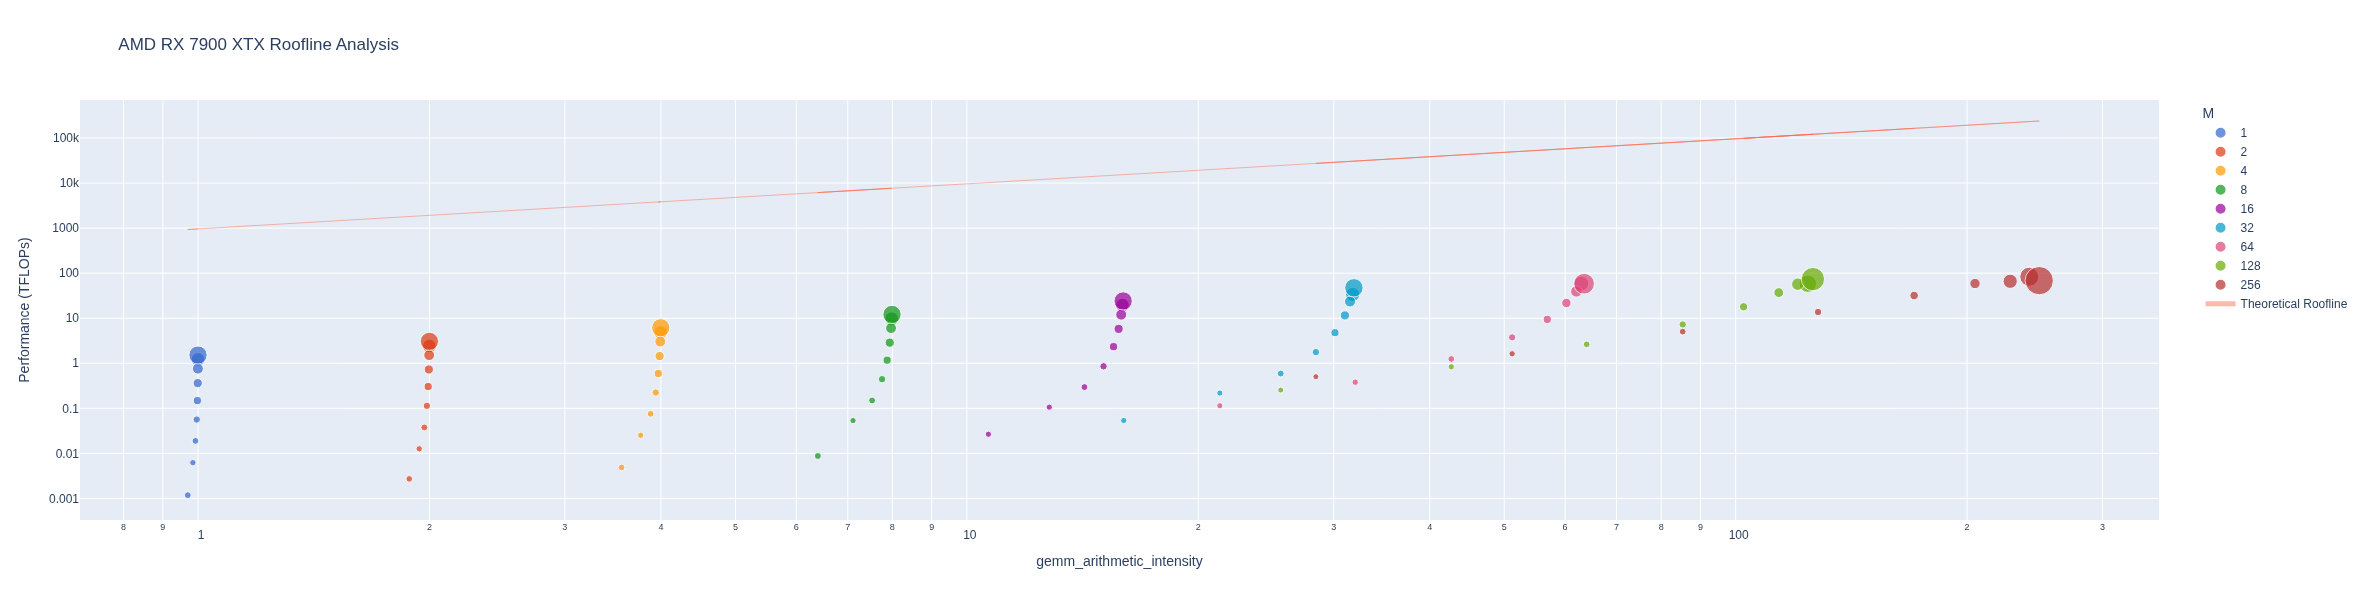

In [33]:
df = load_gemm_data("results/**/INT8/**/")
df = calculate_roofline_data(df, peak_compute, peak_bandwidth)
fig = generate_roofline_plot(df)
fig.show()

In [34]:
df.select(["M","N","K", "gemm_arithmetic_intensity", "tflops", "memory_constraint", "attainable_performance"])

M,N,K,gemm_arithmetic_intensity,tflops,memory_constraint,attainable_performance
i64,i64,i64,f64,f64,f64,f64
16,8192,8192,15.937743,19.5572,15300.233463,15300.233463
8,8192,8192,7.984405,9.74981,7665.02924,7665.02924
128,8192,8192,124.121212,58.2084,119156.363636,119156.363636
2,8192,8192,1.999024,2.42101,1919.062958,1919.062958
64,8192,8192,63.015385,58.77,60494.769231,60494.769231
…,…,…,…,…,…,…
128,1024,1024,102.4,17.9289,98304.0,98304.0
4,1024,1024,3.968992,0.592742,3810.232558,3810.232558
8,1024,1024,7.876923,1.17027,7561.846154,7561.846154


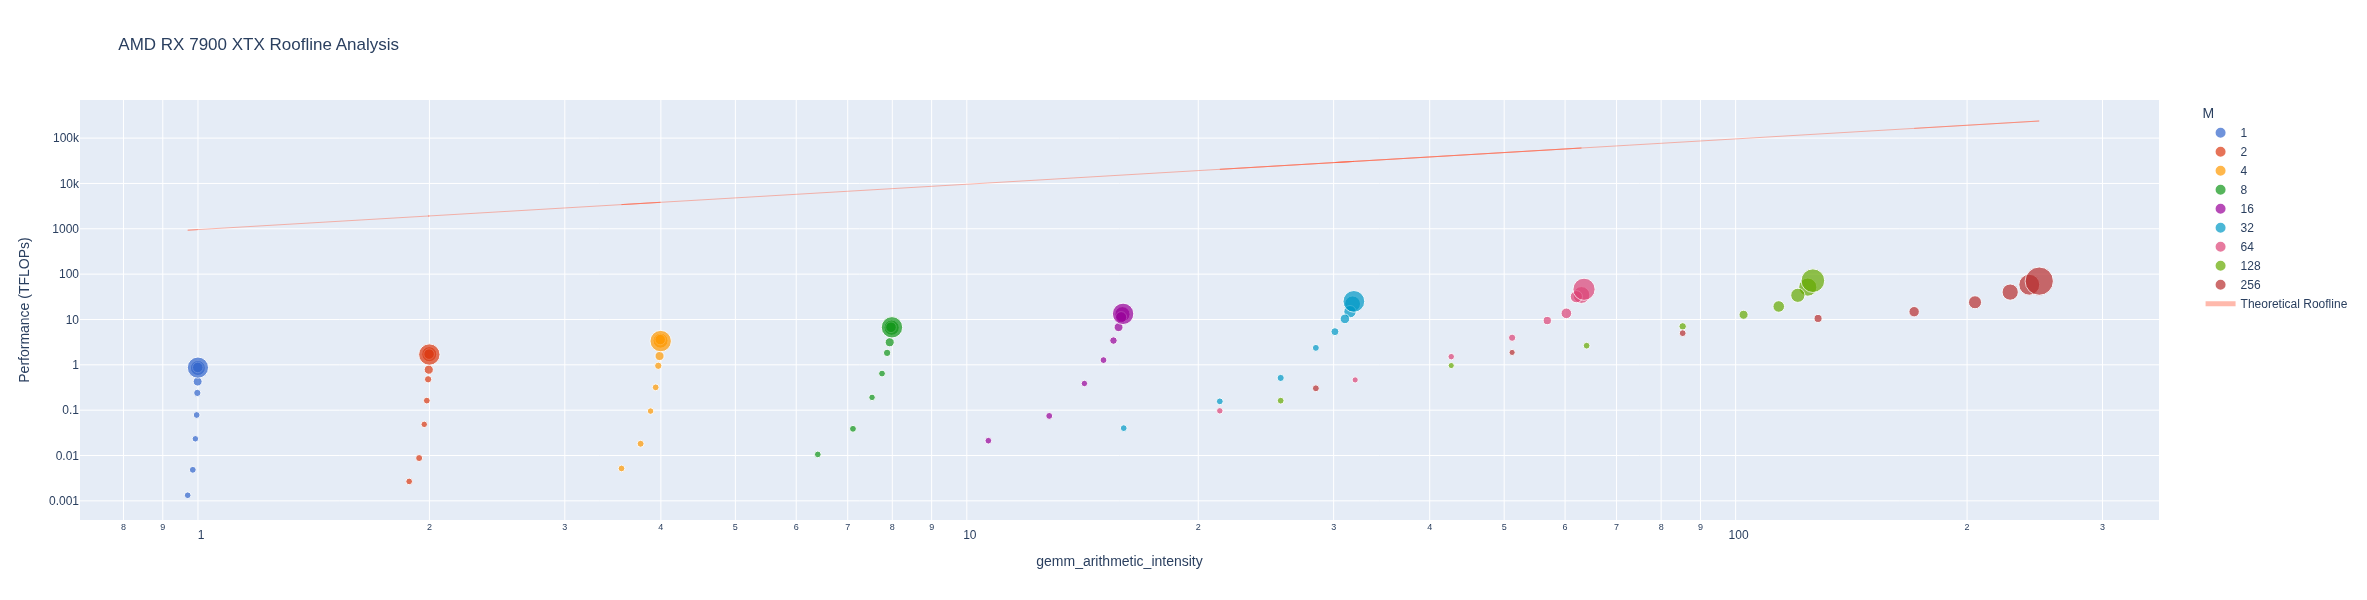

In [26]:
df = load_gemm_data("results/**/FLOAT16/**/")
df = calculate_roofline_data(df, peak_compute, peak_bandwidth)
fig = generate_roofline_plot(df)
fig.show()

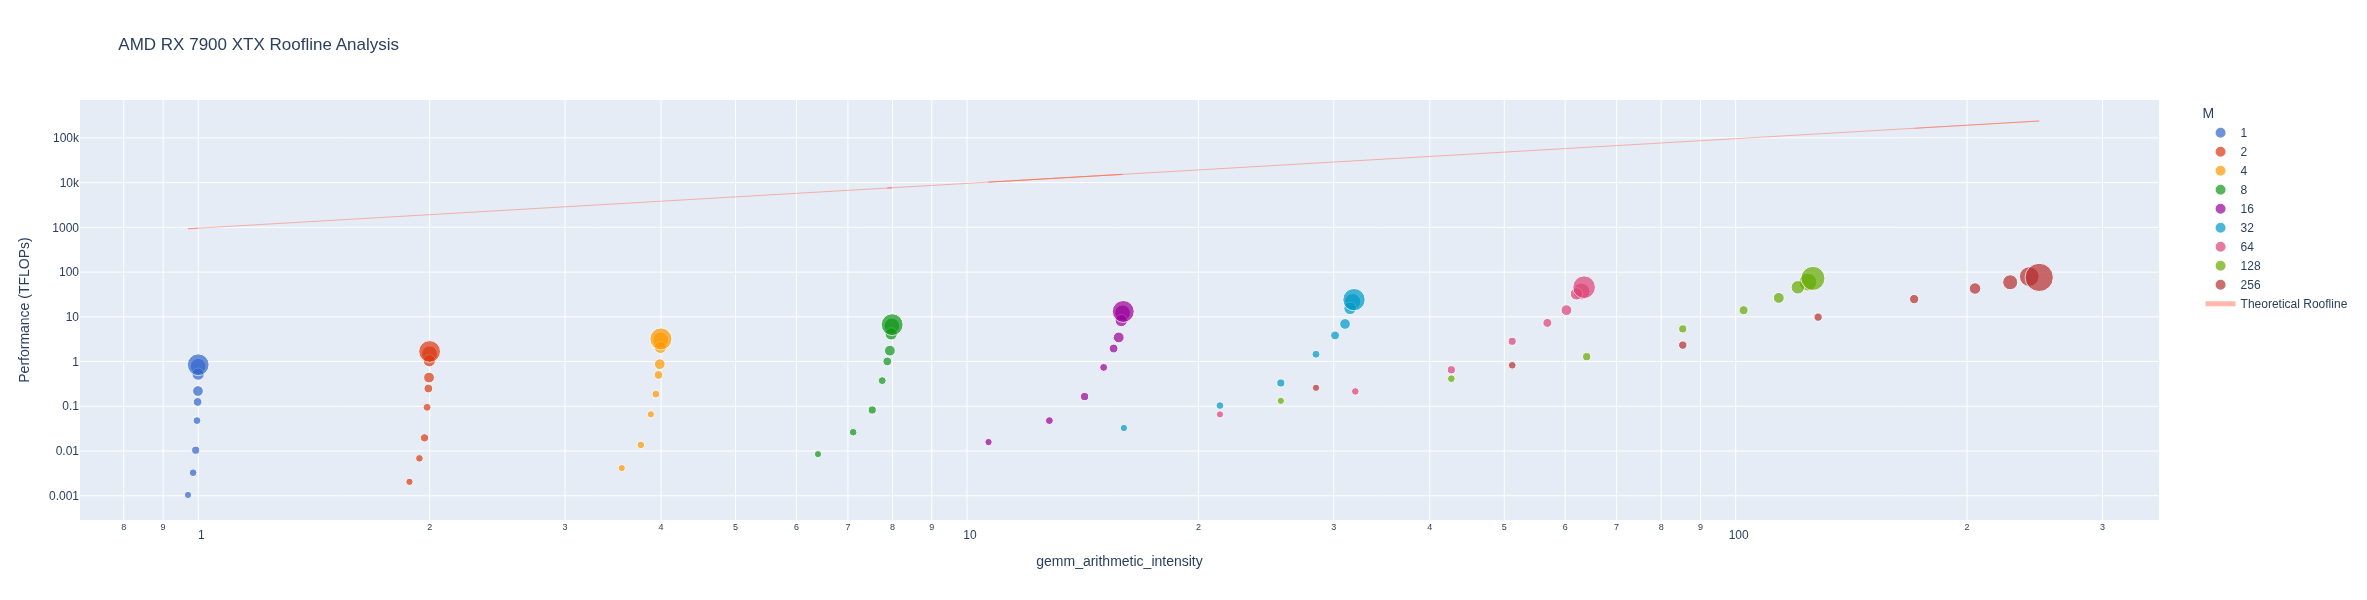

In [27]:
df = load_gemm_data("results/**/BFLOAT16/**/")
df = calculate_roofline_data(df, peak_compute, peak_bandwidth)
fig = generate_roofline_plot(df)
fig.show()

# Float 32

`M=1,2,4` failed so we only see 6 scans

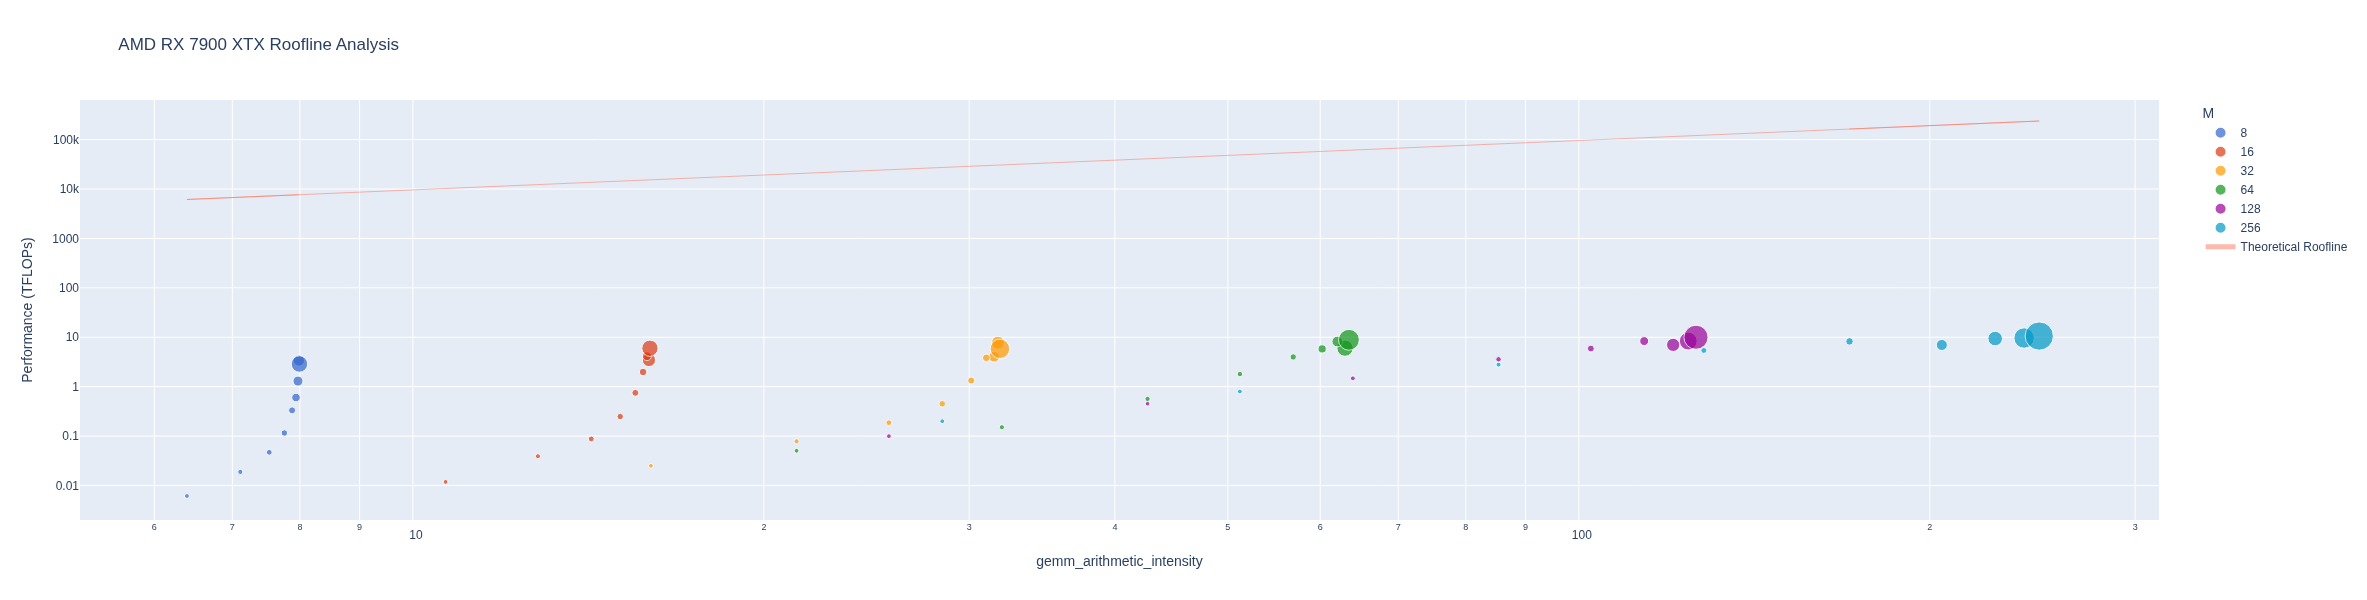

In [28]:
df = load_gemm_data("results/**/FLOAT32/**/")
df = calculate_roofline_data(df, peak_compute, peak_bandwidth)
fig = generate_roofline_plot(df)
fig.show()